С помощью pytorch подгрузим обученную сеть и протестируем ее на нескольких рандомных картинках


In [1]:
from xml.etree import ElementTree
from pathlib import Path
from io import BytesIO
import torch
import torchvision as tv
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import gdown
import matplotlib.patches as mpatch
import pandas as pd

In [2]:
device = torch.device('cuda') if torch.cuda.is_available()\
else torch.device('cpu')

Для работы был выбран датасет с фруктами

*https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection*

In [ ]:
gdown.download(
    'https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM',
    output='34662_46346_bundle_archive.zip', quiet=False)

In [4]:
! unzip -q /content/34662_46346_bundle_archive.zip

Основные этапы

1) Создать класс (наследуется от datasets)

2) Картинки переводим в тензор

3) Парсинг xml - получаем имя класса и координаты box'a 

4) Для передачи в loader преобразуем выход в x,y 

x - list тензоров, каждый тензор - картинка размера [Chanels, Hight, Wight], отнормированная от 0 до 1.

y - list следующих словарей:

 - {Ключ 'boxes'} - Cловарь содержит в себе box формы FloatTensor[N,4], где 4 - это координаты [x1, y1, x2, y2]

 - {Ключ 'labels'} - Здесь только номер классов



In [5]:
labels_code = ['__background__','apple', 'orange', 'banana']

class Fruit_Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mode):
        self.root_dir = root_dir
        self.mode = mode

        p = Path(self.root_dir)
        if mode == 'train':
            p_train = p / 'train_zip' / 'train'
            self.img_jpg = sorted(list(p_train.glob('*.jpg')))
            self.img_xml = sorted(list(p_train.glob('*.xml')))

        if mode == 'test':
            p_train = p / 'test_zip' / 'test'
            self.img_jpg = sorted(list(p_train.glob('*.jpg')))
            self.img_xml = sorted(list(p_train.glob('*.xml')))

    def __len__(self):
        return len(self.img_jpg)

    def __getitem__(self, index):
        image = self.img_jpg[index] 
        label = self.img_xml[index]

        img = (Image.open(image)).convert("RGB")
        img_tensor = tv.transforms.ToTensor()(img)  # X

        tree = ElementTree.parse(label)
        root = tree.getroot()
        

        labels_code = ['__background__','apple', 'orange', 'banana']
        label_iter = []
        coordinate = []
        labels = [] 
        for obj in root.iter('object'):
            coord_iter = []
            for child in obj:
                if child.tag == 'name':
                    label_iter.append(int(labels_code.index(child.text)))
                if child.tag == 'bndbox':
                    for coord in child:
                      coord_iter.append(float(coord.text))
                    coordinate.append(coord_iter)
        coord_tensor = torch.FloatTensor(coordinate)
        label_tensor = torch.LongTensor(label_iter)
        dict_iter = {'boxes': coord_tensor, 'labels': label_tensor} # Y
        labels.append(dict_iter)
        return img_tensor, dict_iter
    

In [6]:
train_set = Fruit_Dataset(root_dir='/content', mode='train')
test_set = Fruit_Dataset(root_dir='/content', mode='test')

In [7]:
def my_collate(batch):
    data = [item[0].to(device) for item in batch]
    target = [item[1] for item in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return data, target

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                           shuffle=True, collate_fn=my_collate)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=False, collate_fn=my_collate)

In [9]:
def parse_xml(xml_file):
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    
    labels_code = ['apple', 'orange', 'banana']
    label_iter = []
    coordinate = []
    for obj in root.iter('object'):
        coord_iter = []
        for child in obj:
            if child.tag == 'name':
                label_iter.append(labels_code.index(child.text))
            if child.tag == 'bndbox':
                for coord in child:
                  coord_iter.append(int(coord.text))
                coordinate.append(coord_iter)
    return label_iter, coordinate

In [10]:
def let_s_paint(folder, number_pictures = 3):
    p_train = Path(folder) / 'train_zip' / 'train'
    images = sorted(list(p_train.glob('*.jpg')))
    boxes = sorted(list(p_train.glob('*.xml')))

    image_index = [np.random.randint(
        0, len(images)) for i in range(number_pictures)]
    
    # отрисовка картинок из train dataset
    fig = plt.figure(figsize=(15,10))
    for i in range(number_pictures):
        add = fig.add_subplot(1, number_pictures, i + 1)
        img = plt.imread(images[image_index[i]])
        plt.imshow(img)

    fig = plt.figure(figsize=(10,10))

    # отрисовка с боксами
    for i in range(number_pictures):
        lab, box_border = parse_xml(boxes[image_index[i]])

        add = fig.add_subplot(1, number_pictures, i + 1)
        img = plt.imread(images[image_index[i]])

        for j in range(len(box_border)):
            rectangle = mpatch.Rectangle((box_border[j][0], box_border[j][1]),
                          box_border[j][2] - box_border[j][0],
                          box_border[j][3] - box_border[j][1],
                          fill=False, linewidth=2, color = 'green')
            plt.text(box_border[j][0], box_border[j][1], labels_code[lab[j]+1],
                     fontsize=12, bbox=dict(facecolor='yellow', alpha=0.4),
                     horizontalalignment='left', verticalalignment='bottom')
            add.add_patch(rectangle)
            plt.imshow(img)
    return 

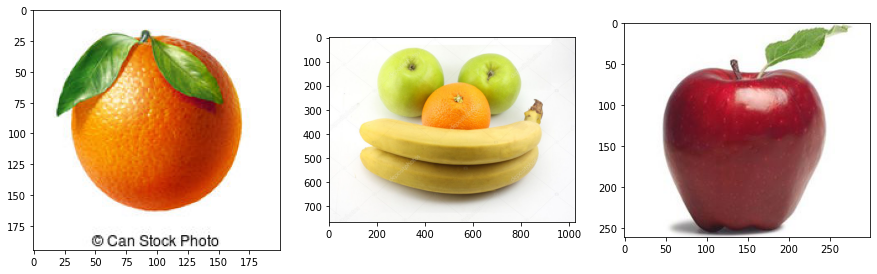

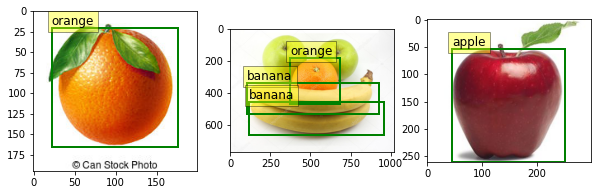

In [11]:
let_s_paint('/content')

In [ ]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True, pretrained_backbone=True)
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

In [13]:
model.to(device);

In [14]:
optim = torch.optim.Adam(model.parameters())

In [15]:
#Train
def train_set(model, optimizer, dataset):
    model.train()
    mega_loss = 0
    for imgs, labs in dataset:
        dict_predict = model(imgs, labs)
        sum_loss = sum(loss for loss in dict_predict.values())
        mega_loss += sum_loss.item()
        optimizer.zero_grad()
        sum_loss.backward()
        optimizer.step()
    print(f'loss for epoch {mega_loss}')
    return mega_loss

In [ ]:
num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f'epoch {epoch}')
    loss = train_set(model, optim, train_loader)
    epoch_loss.append(loss)

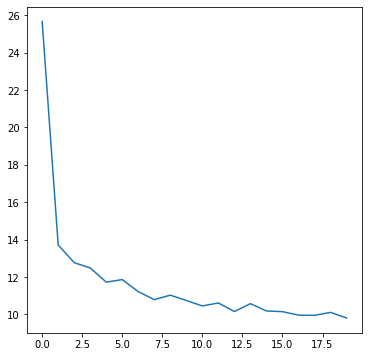

In [17]:
# loss по эпохам
plt.figure(figsize=(6,6))
plt.plot(range(len(epoch_loss)), epoch_loss)

In [18]:
img_apple = requests.get('https://avatars.mds.yandex.net/get-zen_doc/\
175411/pub_5c861c586508fd00b373ce0c_5c862ed859b73700b00c8f1a/scale_1200')\
.content

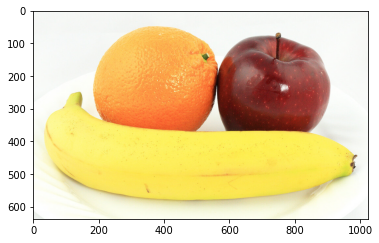

In [19]:
pil_img_apple = Image.open(BytesIO(img_apple))
plt.imshow(pil_img_apple)
model.eval()
img_train = tv.transforms.ToTensor()(pil_img_apple).unsqueeze(0)
img_train = img_train.to(device)
predict = model(img_train)

In [20]:
def paint_it(image_pill, dict_box):
    labels_code = ['0','apple', 'orange', 'banana']
    dict_box = [{k: v.cpu() for k, v in t.items()} for t in dict_box]
    img_np = np.array(image_pill)
    dict_box_np =  dict_box[0]['boxes'][dict_box[0]['scores'] > 0.45]\
                                                        .detach().numpy()
    dict_box_lb = dict_box[0]['labels'][dict_box[0]['scores'] > 0.45]\
                                                        .detach().numpy()
    for i in range(len(dict_box_np)):
        img_rec = cv2.rectangle(
            img_np,
            (dict_box_np[i][0], dict_box_np[i][1]),
            (dict_box_np[i][2], dict_box_np[i][3]),
            255, 3
        )

        cv2.putText(img_np, str(labels_code[dict_box_lb[i]]),\
                    (int(dict_box_np[i][0]), int(dict_box_np[i][1])),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0), 2)
    plt.figure(figsize=(10,10))
    return plt.imshow(img_rec)

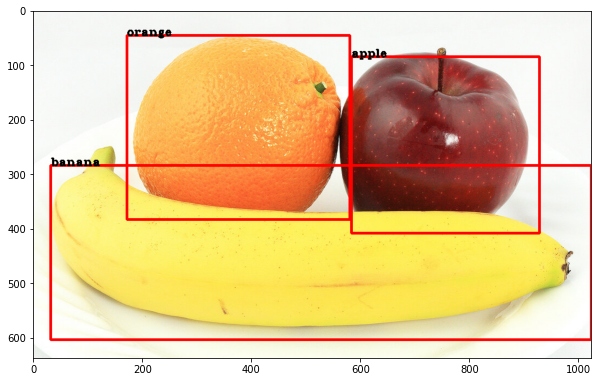

In [21]:
paint_it(pil_img_apple, predict)

In [22]:
def iou_metrics(y_true: list, y_preds: list):
    #  model(x) --> y_preds = [{'boxes':'...', 'labels':'...', 'scores':'...'}]

    #  intersection
    x1 = max(y_true[0], y_preds[0])
    y1 = max(y_true[1], y_preds[1])
    x2 = min(y_true[2], y_preds[2])
    y2 = min(y_true[3], y_preds[3])

    intersect_sq = abs(x1 - x2) * abs(y1 - y2)

    #  union
    #  box_1 - true
    box_1_sq = (y_true[2] - y_true[0]) * (y_true[3] - y_true[1])
    #  box_2 - pred
    box_2_sq = (y_preds[2] - y_preds[0]) * (y_preds[3] - y_preds[1])

    union_sq = box_1_sq + box_2_sq - intersect_sq

    iou = intersect_sq/(union_sq + 0.00001)
    return iou

Необходимо осортировать картинки по лейблам.
В зависимости от лейбла который РАЗМЕЧЕН мы определяем:

    если нет такого класса - это FN
    если такой класс есть, смотрим правильно ли он размечен

Для этого смотрим на размеченный бокс и считаем iou для него и каждого бокса из заданного класса, размеченного сетью. Получаем матрицу, в которой

    если Iou > 1 - пересечения нет и может присваиваться 0
    если Iou >> 1 - также
    если Iou = 0 - это сулчай невозможный вообще

Чем больше IoU для данного размеченного бокса и бокса размеченного сетью, тем лучше. Максимальный iou берем как ответ.

- Получаем матрицу вероятностей.
Максимальным вероятностям в строчке присваиваем 1 (True), а всем остальным 0
Смотрим, чтобы на 1 нарисованный box приходился 1 размеченный сетью

- Считаем сколько получилось лишних box'ов - они FP
Если размеченному box'у не соответствует ничего, то записываем его как FN

- Строим финальную табличку вывод, где записываем

- Выводим метрики для каждой картинки из test: precision, recall и f меру

- Считаем общий precision и recall. Делаем вывод о качетсве модели.

In [23]:
def metrics_for_imgs(y_preds, y_true, pred_class_set):

    FP = 0 
    FN = 0
    TP = 0

    upper_half_preds = y_preds[0]['labels'][y_preds[0]['scores'] > 0.5].shape  
    
    uniq_labels_true = torch.unique(
                            y_true[0]['labels'])  
    uniq_labels_preds = torch.unique(
                            y_preds[0]['labels'][y_preds[0]['scores'] > 0.5])  

    for i in uniq_labels_true:
       
        box_true = y_true[0]['boxes'][y_true[0]['labels'] == i]
        box_pred = y_preds[0]['boxes'][(y_preds[0]['labels'] == i) & 
                                       (y_preds[0]['scores'] > 0.4)]
        iou_matrix = []

        all_box_true = int(box_true.shape[0])

        for k in range(len(box_true)):
            current_true_box = box_true[k]

            iou_list = []
            for j in range(len(box_pred)):
                metric = iou_metrics(current_true_box, box_pred[j])
                iou_list.append(metric.item())
            iou_matrix.append(iou_list)
        
        matr = torch.FloatTensor(iou_matrix)

        x = (matr < 1) & (matr > 0.5)
        matr_with_x = matr * x

        if matr_with_x.shape[1] == 0:
            y = matr_with_x
        else:

            y = matr_with_x.max(1, keepdim=True)[0]
        matr_x_with_y = (matr_with_x == y)

        TP += int(matr_x_with_y.sum()) 
        FN += abs(all_box_true - TP)
        FP += abs(int(upper_half_preds[0]) - TP - FN)
        
        final_matr = matr_with_x * matr_x_with_y  

    return TP, FP, FN

In [24]:
def validation(model, val_set, pred_score = 0.3):
    result = pd.DataFrame(columns=['precision', 'recall', 'f_metric'])
    model.eval()
    precision_ls = []
    recall_ls = []
    f_metric_ls =[]
    with torch.no_grad():

        for img, boxes in val_set:
            y_true = boxes
            y_preds = model(img)

            pred_class = y_preds[0]['labels'][y_preds[0]['scores'] > pred_score]

            pred_class_set = torch.unique(pred_class)
            TP, FP, FN = metrics_for_imgs(y_preds, y_true, pred_class_set)
            precision = TP / (TP + FP)
            recall = TP/ (TP + FN)
            f_metric = 2 * precision * recall / (precision + recall + 0.00001)
      
            precision_ls += [precision]
            recall_ls += [recall]
            f_metric_ls += [f_metric]
    precision_all = sum(precision_ls)/len(precision_ls)
    recall_all = sum(recall_ls)/len(recall_ls)
    f_metric_all = sum(f_metric_ls)/len(f_metric_ls)
    
    print(f'Суммарное значение precision {precision_all},\
     Суммарное значение recall {recall_all},\
      суммарное значение f меры {f_metric_all}')

In [25]:
validation(model, test_loader)

Суммарное значение precision 0.7254911955998914,     Суммарное значение recall 0.961111111111111,      суммарное значение f меры 0.7989790292464284
